<h1>Devops Tesk</h1>

<h3>Import Libraries</h3>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ipaddress

<h3>Read the data</h3>

In [2]:
ips = pd.read_excel("ip_data.xlsx")

<h3>Function to convert IP into binary</h3>

In [3]:
def ip_to_bin(ip):
    IP = ipaddress.IPv4Address(str(ip))
    binary_ip = format(int(IP), '08b')
    return binary_ip

<h3>CIDR calculate</h3>

In [4]:
CIDR_list =[]
Prefix_list = []
for i in ips.values:
    Prefix_length = ip_to_bin(i[1]).count('1')
    CIDR = str(i[0]) + '/' + str(Prefix_length)
    CIDR_list.append(CIDR)
    Prefix_list.append(Prefix_length)
ips = ips.assign(CIDR = CIDR_list)
ips = ips.assign(Prefix_length = Prefix_list)

<h3>Network address calculate</h3>

In [5]:
network_address = []
for i in ips.values:
    net_add = (int(ip_to_bin(i[0]),2) & int(ip_to_bin(i[1]),2))
    net_add = ipaddress.IPv4Address(net_add)
    network_address.append(net_add)
ips = ips.assign(Network_Address = network_address)

<h3>broadcast address calculate</h3>

In [6]:
broadcast_address = []
for i in ips.values:
    x = '1'*(32 - i[3])
    bro_add = (int(ip_to_bin(i[4]),2) | int(x,2))
    bro_add = ipaddress.IPv4Address(bro_add)
    broadcast_address.append(bro_add)
ips = ips.assign(Broadcast_Address = broadcast_address)

<h3>number of usable hosts calculate</h3>

In [7]:
usable_hosts = []
for i in ips.values:
    use_host = pow(2,32-i[3])-2
    usable_hosts.append(use_host)
ips = ips.assign(Number_of_usable_hosts = usable_hosts)

<h3>Overlapping calculate</h3>

In [8]:
overlapping ={}
for i in ips.values:
    for j in ips.values:
        if i[0] == j[0]:
            continue
        if (ipaddress.IPv4Address(i[4]) <= ipaddress.IPv4Address(j[4]) and ipaddress.IPv4Address(i[5]) >= ipaddress.IPv4Address(j[4])) or (ipaddress.IPv4Address(i[4]) <= ipaddress.IPv4Address(j[5]) and ipaddress.IPv4Address(i[5]) >= ipaddress.IPv4Address(j[5])):
            if i[0]in overlapping and j[0] not in overlapping[i[0]]:
                overlapping[i[0]].append(j[0])
            elif i[0] not in overlapping :
                overlapping[i[0]]= [j[0]]
            if j[0]in overlapping and i[0] not in overlapping[j[0]]:
                overlapping[j[0]].append(i[0])
            elif j[0] not in overlapping :
                overlapping[j[0]]= [i[0]]

In [9]:
overlapping_address = []
isOverlapping = []
for i in ips.values:
    if i[0] in overlapping.keys():
        overlapping_address.append(overlapping[i[0]])
        isOverlapping.append(True)
    else:
        overlapping_address.append(None)
        isOverlapping.append(False)        
ips = ips.assign(Overlapping = isOverlapping)
ips = ips.assign(Overlapping_Address = overlapping_address)

<h3>Export the result of calculation</h3>

In [10]:
ips.to_csv("subnet_report_1.csv")

<h3>group the IPs by subnet and CIDR</h3>

In [11]:
ips_g = ips.groupby(["Subnet Mask","Prefix_length"])

<h3>Generate a report about Subnet mask</h3>

In [12]:
summary_report = pd.DataFrame()
for i,x in ips_g:
    num_of_ips = x.shape[0]
    num_of_overlapping = (x["Overlapping"]== True).sum()
    num_of_usable_hosts = x["Number_of_usable_hosts"].min()
    data =[i[0],i[1],num_of_ips,num_of_usable_hosts,num_of_overlapping]
    summary_report = summary_report.append([data])
summary_report.rename(columns={0:"Subnet Mask",1:"CIDR",2:"Number of hosts",3:"Number of usable hosts",4:"Number of overlapping"},inplace=True)

In [13]:
summary_report.to_csv("subnet_report_2.csv")

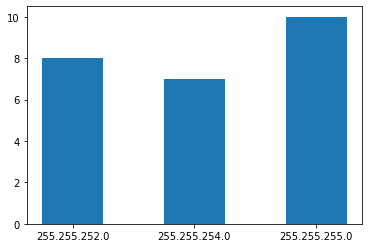

In [14]:
plt.bar(summary_report["Subnet Mask"],summary_report["Number of hosts"],width=0.5)
plt.savefig('Subnet hosts.png', dpi=300)